Mathilde Koch, INRA, Faulon's group.

The aim of this script is to show how the 20 informative points are able to predict the different datasets of 102 points.

# Importing necessary libraries

In [1]:
import sklearn
import numpy as np

import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split

import time
import datetime
import random
import csv
import os
import copy
import warnings

In [2]:
specific_experimentalist = "ORI"

folder_for_data = "data/{}".format(specific_experimentalist)
folder_to_save = "{}".format(specific_experimentalist)
chosen_table = "final_1.csv"

# Defining functions

In [3]:
def present_in_array_index(new_sample, array, size = 11):
    present = False
    new_sample = np.reshape(np.array(new_sample), (1,size))
    for i in range(array.shape[0]):
        if np.array_equiv(array[i,:],new_sample):
            present = True
            break     
    return(present, i)

In [4]:
def get_data_from_row(i, y_mean_total = None, y_std_total = None):
    return(y_mean_total[i], y_std_total[i])

In [5]:
def filling_array_from_data(already_sampled, X_total = None, y_mean_total = None, y_std_total = None):
    means = []
    errors = []
    for row in already_sampled:
        present, i = present_in_array_index(row, X_total)
        mean, error = get_data_from_row(i, y_mean_total = y_mean_total, y_std_total = y_std_total)
        means.append(mean)
        errors.append(error)
    means = np.reshape(means, (np.shape(already_sampled)[0], 1))
    errors = np.reshape(errors, (np.shape(already_sampled)[0], 1))
    completed_array = np.concatenate((already_sampled, means, errors), axis = 1)

    return(already_sampled, means, errors)


In [6]:
def select_current_best_model(X, y, models_number = 10, verbose = False, 
                             MLP = True,
                             visu = False):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    trained_model_list = []
    # Training all models
    for i in range(models_number):
        # X_train, X_test, y_train, y_test, y_error_train, y_error_test = sklearn.model_selection.train_test_split(X, y, y_std, test_size=0.2) 
        X_train, y_train = X, y
        if MLP:
            other_MLP = MLPRegressor(hidden_layer_sizes  = (10, 100,100, 20), solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            other_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(other_MLP)

            big_MLP = MLPRegressor(hidden_layer_sizes  = (100,100, 20),solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            big_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(big_MLP)


            medium_MLP = MLPRegressor(hidden_layer_sizes  = (40, 10), solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            medium_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(medium_MLP)
  
            small_MLP = MLPRegressor(hidden_layer_sizes  = (10), solver ="adam", max_iter=20000, 
                                      early_stopping = True, learning_rate = "adaptive")
            small_MLP.fit(X_train, y_train.flatten())    
            trained_model_list.append(small_MLP)
        
    # Evaluating all 
    all_scores = []
    for i in range(len(trained_model_list)):
        selected_mdoel = trained_model_list[i]
        y_pred = selected_mdoel.predict(X)
        score = sklearn.metrics.r2_score(y, y_pred)
        all_scores.append(score)

    try:
        best_index = all_scores.index(max(all_scores))
        best_score = all_scores[best_index]
    except ValueError:
        best_index = 0
    if verbose:
        print(all_scores)
        print("Best index is {}".format(best_index))
        print("Best score is {}".format(best_score))
    best_model = trained_model_list[best_index]
    if visu:
        sample_weight_total = (1/(y_std*y_std))
        
        model = best_model
        y_pred = model.predict(X)
        score = sklearn.metrics.r2_score(y, y_pred)
        fig, ax = plt.subplots()
        ax.scatter(y, y_pred, edgecolors=(0, 0, 0))
        ax.errorbar(y, y_pred,xerr = y_std, ls='none')
        ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
        ax.set_xlabel('Measured')
        ax.set_title("Model prediction for model {}: {}".format(i, score))
        ax.set_ylabel('Predicted')
        plt.show()
    return(best_model, best_score)

In [7]:
def obtain_split_score(X_train, X_test, y_train, y_test, 
                      ensemble_size = 25, models_number_repeat = 10):
    # Training ensemble models
    
    ensemble_models = []
    for n in range(ensemble_size):
        current_best, best_score = select_current_best_model(X_train, y_train,
                                                            models_number = models_number_repeat, verbose = False, 
                                                             MLP = True,
                                                             visu = False)
        ensemble_models.append(current_best)
    # evaluating the models
    all_predictions = None
    all_predictions_on_train = None
    for model in ensemble_models:
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        answer_array_pred = y_pred.reshape(X_test.shape[0], -1)
        answer_array_pred_train = y_pred_train.reshape(X_train.shape[0], -1)
        if all_predictions is None:
            all_predictions = y_pred.reshape(X_test.shape[0], -1)
            all_predictions_on_train = y_pred_train.reshape(X_train.shape[0], -1)
        else:
            all_predictions =np.concatenate((all_predictions, y_pred.reshape(X_test.shape[0], -1)), axis = 1)
            all_predictions_on_train =np.concatenate((all_predictions_on_train, y_pred_train.reshape(X_train.shape[0], -1)), axis = 1)

    y_pred, y_pred_std = np.mean(all_predictions, axis = 1), np.std(all_predictions, axis = 1)
    y_pred_train, y_pred_std_train = np.mean(all_predictions_on_train, axis = 1), np.std(all_predictions_on_train, axis = 1)
    score = sklearn.metrics.r2_score(y_test, y_pred)
    y_pred_train = y_pred_train.reshape(y_pred_train.shape[0], -1)
    y_pred_std_train = y_pred_std_train.reshape(y_pred_std_train.shape[0], -1)
    y_pred = y_pred.reshape(y_pred.shape[0], -1)
    y_pred_std = y_pred_std.reshape(y_pred_std.shape[0], -1)
    
    return(score, y_pred_train, y_pred_std_train, y_pred, y_pred_std)

In [8]:
def handle_results(score, 
                   X_train, X_test, y_train, y_test, y_std_train, y_std_test, 
                   y_pred_train, y_pred_std_train, y_pred, y_pred_std,
                   best_tests):
    if len(best_tests) < 5:
        best_tests.append({"score": score, "X": X_train, 
                          "X_test": X_test, "y_train": y_train, 
                           "y_test": y_test, "y_std_train": y_std_train, "y_std_test": y_std_test, 
                          "y_pred_train": y_pred_train, "y_pred_std_train": y_pred_std_train, 
                           "y_pred": y_pred, "y_pred_std": y_pred_std})
    else:
        minimal_element = best_tests[0]
        for element in best_tests:
            score_element = element["score"]
            if score_element <minimal_element["score"]:
                minimal_element = element
        if score > minimal_element["score"]:
            best_tests.remove(minimal_element)
            best_tests.append({"score": score, "X": X_train, 
                          "X_test": X_test, "y_train": y_train, 
                           "y_test": y_test, "y_std_train": y_std_train, "y_std_test": y_std_test, 
                          "y_pred_train": y_pred_train, "y_pred_std_train": y_pred_std_train, 
                           "y_pred": y_pred, "y_pred_std": y_pred_std})
    return(best_tests)


In [9]:
def save_results(best_tests, initial_max, base_name = "final", folder_to_save = "test", visu = False):
    index = 0
    for element in best_tests:
        index = index + 1
        score_element = element["score"]
        headers = "nad;folinic_acid;coa;nucleo_mix;spermidin;pga;aa;trna;mg_gluta;camp;K_gluta"
        file_to_write = "{}/{}_{}.csv".format(folder_to_save, base_name, index)
        X = copy.deepcopy(element["X"])
        for i in range(X.shape[1]):
            X[:,i] = X[:,i]*initial_max[i]
        np.savetxt(file_to_write, X, delimiter=";", header = headers,fmt='%.6f')
        if visu:
            fig, ax = plt.subplots()
            ax.scatter(element["y_test"], element["y_pred"], edgecolors=(0, 0, 0))
            ax.errorbar(element["y_test"], element["y_pred"], 
                                xerr = element["y_std_test"], yerr = element["y_pred_std"], ls='none')
            score = score_element
            ax.set_xlabel('Measured')
            ax.set_title("R squared is: {} for {} - {}".format(round(score, 2), base_name, index))
            ax.set_ylabel('Predicted')
            ax.scatter(element["y_train"], element["y_pred_train"], edgecolors='red')
            ax.errorbar(element["y_train"], element["y_pred_train"], 
                                xerr = element["y_std_train"], yerr = element["y_pred_std_train"], 
                        ls='none', ecolor = "red")
            ax.plot([element["y_test"].min(), element["y_test"].max()],
                     [element["y_test"].min(), element["y_test"].max()], 'k--', lw=4)
            name_for_plotting = "{}/{}_{}_model_vs_data.png".format(folder_to_save, base_name, index)
            plt.savefig(name_for_plotting)
            plt.show()

In [10]:
def obtaining_rest_of_data(already_sampled, X_total = None, y_mean_total = None, y_std_total = None):
    means = []
    errors = []
    X_test = None
    for row in X_total:
        present_in_starting, i = present_in_array_index(row, already_sampled)
        if not present_in_starting:
            present, i = present_in_array_index(row, X_total)
            mean, error = get_data_from_row(i, y_mean_total = y_mean_total, y_std_total = y_std_total)
            means.append(mean)
            errors.append(error)
            if X_test is None:
                X_test = np.reshape(row, (1, 11))
            else:
                X_test = np.concatenate((X_test, np.reshape(row, (1, 11))), axis = 0)
    means = np.reshape(means, (len(means), 1))
    errors = np.reshape(errors, (len(means), 1))
    completed_array = np.concatenate((X_test, means, errors), axis = 1)

    return(X_test, means, errors)

In [11]:
def data_from_iteration(iteration_number = 1):
    """
    Obtain data from the desired number of iterations, and not the whole data.
    """
    full_plates_list = [plate_1_array, plate_2_array, plate_3_array, plate_4_array, plate_5_array,
                        plate_6_array, plate_7_array, plate_8_array, plate_9_array, plate_10_array]
    selected_plates = full_plates_list[0:iteration_number]
    current_data = np.concatenate(selected_plates, axis = 0)
    return(current_data)

# Importing data from study

In [12]:
data = np.genfromtxt("{}/102_points.csv".format(folder_for_data), delimiter=',', skip_header = 1,dtype = "float")
X_data, y_data, y_std_data = data[:, 0:11], data[:, 11], data[:, 12]

In [13]:
chosen_X = np.genfromtxt(chosen_table, delimiter=',', skip_header  = 1, dtype = "float")
X_train, y_train, y_std_train = filling_array_from_data(chosen_X,
                                                        X_total = X_data, 
                                                        y_mean_total = y_data, 
                                                        y_std_total = y_std_data)

X_test, y_test, y_std_test = obtaining_rest_of_data(chosen_X,
                                                    X_total = X_data, 
                                                    y_mean_total = y_data, 
                                                    y_std_total = y_std_data)

In [14]:
initial_max = []
initial_max_test = []
for i in range(X_train.shape[1]):
    initial_max.append(max(X_train[:,i]))
    X_train[:,i] = X_train[:,i]/max(X_train[:,i])
for i in range(X_test.shape[1]):
    initial_max_test.append(max(X_test[:,i]))
    X_test[:,i] = X_test[:,i]/max(X_test[:,i])

In [15]:
assert initial_max_test == initial_max
print(initial_max_test)

[0.33, 0.068, 0.26, 1.5, 1.0, 30.0, 1.5, 0.2, 4.0, 0.75, 80.0]


# Analysing the specific plate we are interested in

First, we will import the data from the various iterations.
Then, we will verify the results from the plate that was selected for further study.

Calling the above functions, we will generate most informative points for the chosen table on the full dataset. 
Parameters to define:
- ensemble_size: number of models in the ensemble of models
- models_number_repeat: number of times the model is trained

The parameters used for the article were:
- ensemble_size: 25
- models_number_repeat: 10


In [16]:
ensemble_size = 25
models_number_repeat = 10
visu = True

In [17]:
score, y_pred_train, y_pred_std_train, y_pred, y_pred_std = obtain_split_score(X_train, X_test, y_train, y_test, 
                               ensemble_size = ensemble_size, models_number_repeat = models_number_repeat)
best_test = handle_results(score, 
                           X_train, X_test, y_train, y_test, y_std_train, y_std_test, 
                           y_pred_train, y_pred_std_train, y_pred, y_pred_std, 
                           [])

/home/mkoch/miniconda3/envs/al/lib/python3.6/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  app.launch_new_instance()
/home/mkoch/miniconda3/envs/al/lib/python3.6/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


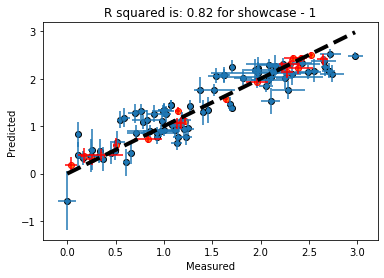

In [18]:
save_results(best_test, initial_max = initial_max, base_name = "showcase", folder_to_save = folder_to_save, visu = True)
headers = "nad;folinic_acid;coa;nucleo_mix;spermidin;pga;aa;trna;mg_gluta;camp;K_gluta;y_data;y_data_std;y_pr;y_std_pr"

for i in range(X_train.shape[1]):
    X_train[:,i] = X_train[:,i]*initial_max[i]

for i in range(X_test.shape[1]):
    X_test[:,i] = X_test[:,i]*initial_max[i]

total_train = np.concatenate((X_train, y_train, y_std_train, y_pred_train, y_pred_std_train), axis = 1)
total_pr = np.concatenate((X_test, y_test, y_std_test, y_pred, y_pred_std), axis = 1)
    
file_to_write_train = "{}/train.csv".format(folder_to_save)
np.savetxt(file_to_write_train, total_train, delimiter=";", header = headers,fmt='%.6f')
# Testing data
file_to_write_test = "{}/test.csv".format(folder_to_save)
np.savetxt(file_to_write_test, total_pr, delimiter=";", header = headers,fmt='%.6f')